In [ ]:
'''
model = nn_model.create(numNeurons, activations=["relu", "sig"])
predictor = model.fit(Xtrain, Ytrain)
f1, acc = predictor.eval(Xval, Yval)
prediction = predictor.pred(x)
'''
# define network architecture

In [2]:
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
def to_one_hot(num_classes, arr):
    return np.eye(num_classes)[arr.reshape(-1)]

raw = loadmat('handDigits.mat')
X = raw['X']
Y = raw['y']

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.6)
del raw, X, Y

# 0 is 10 in origional matlabe data -> change back
Ytrain = np.where(Ytrain == 10, 0, Ytrain)
Ytest = np.where(Ytest == 10, 0, Ytest)

Ytrain = to_one_hot(10, Ytrain)
Ytest = to_one_hot(10, Ytest)

print('training set: ', Xtrain.shape, '  , training labels: ', Ytrain.shape)
print('test set: ', Xtest.shape, '  , test labels: ', Ytest.shape)

training set:  (3000, 400)   , training labels:  (3000, 10)
test set:  (2000, 400)   , test labels:  (2000, 10)


In [5]:
class nn_model:
    
    weights=None
    activations=None
    dims=None
    L = None
    lin_values = {}
    act_values = {}
    grads = {}
    J_hist = []

    def __init__(self, neuronLayers, activations):
        self.activations = activations
        self.dims = neuronLayers+1
        self.L = len(activations)
        weights = {}
        for i in range(self.L):
            weightMat = self.initialise_weights(neuronLayers[i], neuronLayers[i+1])
            weights["W"+str(i+1)] = weightMat
            weights["b"+str(i+1)] = 0
            self.weights = weights
            
    def initialise_weights(self, n_curr, n_next):
        mu = 0
        sigma = 1
        weightMat = np.random.normal(mu, sigma, (n_next,n_curr))*0.01
        return weightMat
    
    def sigmoid(self, Z):
        return 1/(1+np.exp(-Z))

    def forward_prop(self, X): # weights, activation
        self.act_values['A0'] = X.T
        L = int(len(self.weights)/2)
        A = X.T
        for i in range(1,L+1):
            W = self.weights['W'+str(i)]
            b = self.weights['b'+str(i)]
            Z = np.dot(W, A)+b
            if self.activations[i-1] == "relu":
                boolMat = Z > 0
                A = Z*boolMat
            else:
                A = self.sigmoid(Z)
            self.lin_values['Z'+str(i)] = Z
            self.act_values['A'+str(i)] = A
            
    def compute_cost(self, Y):
        Y = Y.T
        Yhat = self.act_values['A'+str(self.L)]
        m = Yhat.shape[1]
        J = -(1/m)*np.sum(Y*np.log(Yhat)+(1-Y)*np.log(1-Yhat))
        return J
    
    def back_prop(self, Y):
        Y = Y.T
        m = Y.shape[1]
        L = self.L

        AL = self.act_values['A'+str(L)]
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

        dA = dAL
        for l in reversed(range(1, L+1)):
            Z = self.lin_values['Z'+str(l)]
            dZ = dA*self.sigmoid(Z)*(1-self.sigmoid(Z))

            dW = (1/m)*np.dot(dZ, self.act_values['A'+str(l-1)].T)
            self.grads['dW'+str(l)] = dW

            db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
            self.grads['db'+str(l)] = db

            W = self.weights['W'+str(l)]
            dA = np.dot(W.T, dZ)
            
    def update_weights(self, learning_rate):
        for key in self.weights:
            self.weights[key] = self.weights[key] - learning_rate*self.grads['d'+key]
            
    def fit(self, Xtrain, Ytrain, learning_rate=0.01, num_itter=1000):
        
        for i in range(num_itter):
            self.forward_prop(Xtrain)
            self.J_hist.append(self.compute_cost(Ytrain))
            self.back_prop(Ytrain)
            self.update_weights(learning_rate)

In [6]:
neurons = np.array([400, 20, 10])
model = nn_model(neurons, ["relu", "sig"])

print(model.activations)
print(model.dims)
print(model.weights.keys())
for key in model.weights:
    temp = np.asarray(model.weights[key])
    print(temp.shape)

['relu', 'sig']
[401  21  11]
dict_keys(['W1', 'b1', 'W2', 'b2'])
(20, 400)
()
(10, 20)
()


In [7]:
model.forward_prop(Xtrain)

print(model.lin_values.keys())
print(model.act_values.keys())
print(Xtrain.T == model.act_values['A0'])
for key in model.act_values:
    print(model.act_values[key].shape)

dict_keys(['Z1', 'Z2'])
dict_keys(['A0', 'A1', 'A2'])
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
(400, 3000)
(20, 3000)
(10, 3000)


In [9]:
J = model.compute_cost(Ytrain)

print(J)

6.932173756388249


In [10]:
model.back_prop(Ytrain)
print(model.grads.keys())
for key in model.weights:
    temp = np.asarray(model.grads['d'+key])
    temp2 = np.asarray(model.weights[key])
    print(temp.shape, temp2.shape)

dict_keys(['dW2', 'db2', 'dW1', 'db1'])
(20, 400) (20, 400)
(20, 1) ()
(10, 20) (10, 20)
(10, 1) ()


In [11]:
model.fit(Xtrain, Ytrain)

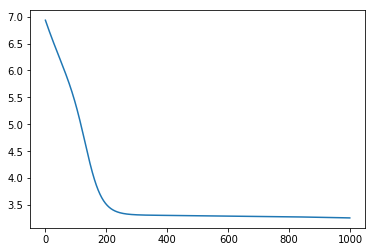

In [12]:
plt.plot(model.J_hist)

In [ ]:
# old
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def forward_prop(X, weights, activation):
    lin_values = {}
    act_values = {}
    act_values['A0'] = X.T
    L = int(len(weights)/2)
    A = X.T
    for i in range(1,L+1):
        W = weights['W'+str(i)]
        b = weights['b'+str(i)]
        Z = np.dot(W, A)+b
        if activation[i-1] == "relu":
            boolMat = Z > 0
            A = Z*boolMat
        else:
            A = sigmoid(Z)
        lin_values['Z'+str(i)] = Z
        act_values['A'+str(i)] = A
    return lin_values, act_values
    
def cost(Yhat, Y):
    m = Yhat.shape[1]
    Y = Y.T
    J = -(1/m)*np.sum(Y*np.log(Yhat)+(1-Y)*np.log(1-Yhat))
    return J

def back_prop(weights, lin_values, act_values, activations, Y):
    Y = Y.T
    m = Y.shape[1]
    L = len(activations)
    
    AL = act_values['A'+str(L)]
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    dA = dAL
    grads = {}
    for l in reversed(range(1, L+1)):
        Z = lin_values['Z'+str(l)]
        dZ = dA*sigmoid(Z)*(1-sigmoid(Z))
        
        dW = (1/m)*np.dot(dZ, act_values['A'+str(l-1)].T)
        grads['dW'+str(l)] = dW

        db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
        grads['db'+str(l)] = db
        
        W = weights['W'+str(l)]
        dA = np.dot(W.T, dZ)
    return grads

def update_weights(weights, grads, learning_rate):
#     print(weights.keys())
#     print(grads.keys())
    for key in weights:
        weights[key] = weights[key] - learning_rate*grads['d'+key]
    return weights

def fit(Xtrain, Ytrain, weights, activations):
    L = int(len(weights)/2)
    lin_values, act_values = forward_prop(Xtrain, weights, activations)
    
    AL = act_values['A'+str(L)]
    J = cost(AL, Ytrain)
    print(J)
    
    grads = back_prop(weights, lin_values, act_values, activations, Ytrain)
    print(grads['dW1'] == model.grads['dW1'])
    
    opt_weights = update_weights(weights, grads, 0.001)

    return opt_weights

act_values = fit(Xtrain, Ytrain, model.weights, ["relu", "sig"])
# print(act_values['A1'].shape)
# print(act_values['A2'].shape)

# ** fix yhat ytrain shapes -> compute cost -> back propergation